In [0]:
%%capture
%%bash
# FILE=$1

# if [[ $FILE != "ae_photos" && $FILE != "apple2orange" && $FILE != "summer2winter_yosemite" &&  $FILE != "horse2zebra" && $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" && $FILE != "maps" && $FILE != "cityscapes" && $FILE != "facades" && $FILE != "iphone2dslr_flower" && $FILE != "ae_photos" ]]; then
#     echo "Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos"
#     exit 1
# fi
FILE='monet2photo'
URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE
mkdir -p ./datasets
wget -N $URL -O $ZIP_FILE
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

# Adapt to project expected directory heriarchy
mkdir -p "$TARGET_DIR/train" "$TARGET_DIR/test"
mv "$TARGET_DIR/trainA" "$TARGET_DIR/train/A"
mv "$TARGET_DIR/trainB" "$TARGET_DIR/train/B"
mv "$TARGET_DIR/testA" "$TARGET_DIR/test/A"
mv "$TARGET_DIR/testB" "$TARGET_DIR/test/B"
pip install opencv-contrib-python

# get the cyclegan library
git clone https://github.com/sachinruk/PyTorch-CycleGAN.git
mv ./PyTorch-CycleGAN/* .

1072
6287
(256, 256, 3)


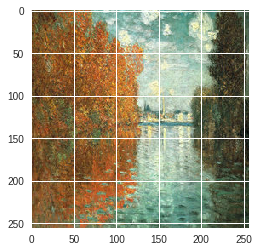

(256, 256, 3)


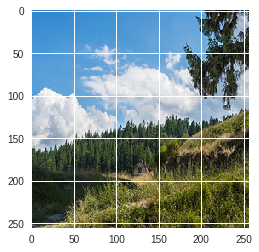

In [3]:
import glob
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

filesA = glob.glob('./datasets/monet2photo/train/A/*.jpg')
filesB = glob.glob('./datasets/monet2photo/train/B/*.jpg')
print(len(filesA))
print(len(filesB))


img = cv2.imread(filesA[0])
print(img.shape)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

img = cv2.imread(filesB[0])
print(img.shape)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [4]:
!python train.py --dataroot ./datasets/monet2photo/ --batchSize 16 --n_cpu 4 --cuda

Process Process-3:
Process Process-4:
Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessin

In [0]:
class Opts():
  pass

opt = Opts()
opt.cuda = True
opt.input_nc = 3
opt.output_nc = 3
opt.epoch = 0
opt.n_epochs = 200
opt.lr = 2e-4
opt.decay_epoch = 100
opt.size = 256
opt.batchSize = 8
opt.n_cpu = 4
opt.dataroot= './datasets/monet2photo/'


In [9]:
#!/usr/bin/python3

import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torch.autograd import Variable
from PIL import Image
import torch

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import LambdaLR
# from utils import Logger
from utils import weights_init_normal
from datasets import *

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.BCEWithLogitsLoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()


# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Tensor(opt.batchSize).fill_(1.0)
target_fake = Tensor(opt.batchSize).fill_(0.0)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
# transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
transforms_ = [ RandomCrop(), 
                RandomFlip(),
                Normalize(),
                ToTensor() ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)

/content/utils.py:52: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


In [10]:
%%time
for epoch in range(opt.epoch, 1):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = input_A.copy_(batch['A'])
        real_B = input_B.copy_(batch['B'])

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake.squeeze(), target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake.squeeze(), target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real.squeeze(), target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake.squeeze(), target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real.squeeze(), target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake.squeeze(), target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
    print(epoch)

RuntimeError: ignored

In [17]:
i

612

In [18]:
len(dataloader)

3144